In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

In [16]:
u0 = torch.tensor(2)
def u(t, lam=0):
    return u0*torch.exp(lam*t)

def F(u, lam):
    return lam * u
t_i = torch.zeros(1,1)
u_i = u(t_i)

In [38]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam
                ):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                          out_features=N_hid,
                          bias=True),
                nn.Sigmoid(),
                nn.Linear(in_features=N_hid,
                          out_features=N_out,
                          bias=True)
        )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        
    def forward(self, t, lam):
        x = torch.hstack((t, lam))
        out = self.layers(x)
        return out
    
    def loss_initial(self, t_i, u_i, lam):
        u_i_hat = self.forward(t_i.repeat(lam.shape), lam)
        loss = self.loss_func(u_i.repeat(lam.shape), u_i_hat)
        return loss

    def loss_ODE(self, t, F, lam):
        u_hat = self.forward(t, lam)
        u_t_hat = torch.autograd.grad(u_hat, t, torch.ones(t.shape), create_graph=True)[0]
        loss = self.loss_func(F(u_hat, lam), u_t_hat)
        return loss
    
    def loss(self, t, F, lam, t_i, u_i):
        loss = self.loss_initial(t_i, u_i, lam) + self.loss_ODE(t, F, lam)
        return loss
    
    def step(self, t, F, lam, t_i, u_i):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(t, F, lam, t_i, u_i)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return self.loss_initial(t_i, u_i, lam), self.loss_ODE(t, F, lam)

In [61]:
loss = []
epochs = 30000
N_in = 1
N_out = 1
n_t = 10
net = Net(N_in=2, N_out=1, N_hid=10)
for e in range(epochs):
    t = torch.rand(n_t, 1, requires_grad=True)*2 # [0, 2]
    lam = (torch.rand(n_t, 1)-0.5)*2 # [-1, 1]
    loss.append(net.step(t, F, lam, t_i, u_i))

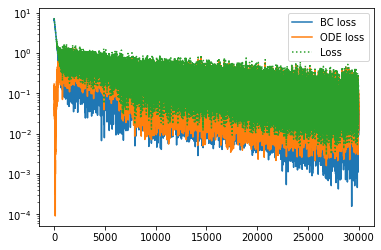

In [62]:
plt.semilogy([bc.detach() for bc, ode in loss], label='BC loss')
plt.semilogy([ode.detach() for bc, ode in loss], label='ODE loss')
plt.semilogy([ode.detach() + bc.detach() for bc, ode in loss], label='Loss', ls='dotted')


plt.legend()

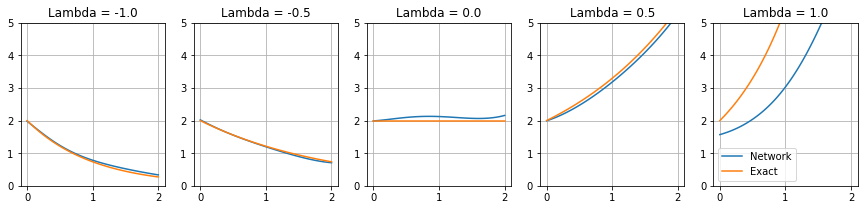

In [65]:
t_lin = torch.linspace(0,2,100).reshape(-1,1)
lam = torch.tensor(0.5).repeat(t_lin.shape)

fig, axs = plt.subplots(1,5,figsize=(15,3))
for k, ax in enumerate(axs):
    l = k*0.5-1
    lam = torch.tensor(l).repeat(t_lin.shape)
    ax.plot(t_lin.detach(), net(t_lin, lam).detach(), label='Network')
    ax.plot(t_lin.detach(), u(t_lin, lam).detach(), label='Exact')
    ax.set_title('Lambda = {}'.format(l))
    ax.set_ylim([0, 5])
    ax.grid()
ax.legend()